# Mixing below a confluence

#### This notebook analyses the mixing from CT-5 and CT-6 parents to the downstream children, CT-4 -> CT-10 -> CT-11 -> CT-8.2
To better understand this downstream mixing analyses of both detrital zircon data and Be-10 data are used

### Understanding downstream mixing vs zircon distribution

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import geopandas as gpd
import rasterio
import csv
from rasterio.plot import show
from geopy.distance import geodesic

In [3]:
%cd /Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Mixing_below_confluence

/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Mixing_below_confluence


In [4]:
# Load your Excel file into a DataFrame 
df = pd.read_excel('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/MataquitoSampleData.xlsx') 

# Print the DataFrame to display its contents
print(df)

   Sample_ID Sample_Type   Latitude  Longitude  Source_Area  Elevation  \
0       CT-1  river sand -35.261470 -71.042330     1385.185        550   
1       CT-2  river sand -35.038830 -72.067050     5760.128         11   
2       CT-3  river sand -35.100380 -71.946720      189.205         18   
3       CT-4  river sand -35.027690 -71.487020     4706.717        111   
4       CT-5  river sand -34.962640 -71.359940     1495.897        155   
5       CT-6  river sand -34.984880 -71.342700     2573.245        158   
6       CT-7  river sand -35.003550 -70.827530     1207.810        631   
7       CT-8  river sand -35.092222 -71.647745     4950.395         78   
8       CT-9  river sand -35.046389 -72.101111     6189.716          9   
9      CT-10  river sand -35.049444 -71.550000     4864.942        102   
10     CT-11  river sand -35.064167 -71.610278     4913.334         89   

    Virtual_Elevation  Surface_Production_Rate  Shielding_Factor  Quartz  \
0             2261.20              

In [5]:
def calculate_downstream_distances(df, sample_names, reference_sample='CT-4', ct4_distance_from_confluence=12.0):
    """
    Calculate downstream distances between samples based on lat/long coordinates.
    CT-4 is set as reference point at 12 km from confluence, other distances calculated relative to CT-4.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with sample data including lat/long columns
    sample_names : list
        List of sample names to calculate distances for
    reference_sample : str
        Reference sample for distance calculation (default: 'CT-4')
    ct4_distance_from_confluence : float
        Distance of CT-4 from confluence in km (default: 12.0)
    
    Returns:
    --------
    dict : Dictionary with sample names as keys and distances from confluence as values
    """
    
    # Initialize dictionary to store coordinates for each sample
    sample_coords = {}
    for sample in sample_names:
        # Search for sample in DataFrame using case-insensitive partial matching
        sample_row = df[df['Sample_ID'].str.contains(sample, case=False, na=False)]
        if not sample_row.empty:
            # Extract latitude and longitude from first matching row
            lat = sample_row['Latitude'].iloc[0]
            lon = sample_row['Longitude'].iloc[0]
            sample_coords[sample] = (lat, lon)
        else:
            print(f"Warning: Sample '{sample}' not found in DataFrame")
    
    # Set reference sample (CT-4) for distance calculations
    if reference_sample not in sample_coords:
        print(f"Warning: Reference sample '{reference_sample}' not found, using first available sample")
        reference_sample = list(sample_coords.keys())[0]
        ct4_distance_from_confluence = 0.0  # Reset if CT-4 not found
    
    ref_coords = sample_coords[reference_sample]
    distances = {}
    
    # Calculate distances from confluence for each sample
    for sample, coords in sample_coords.items():
        if sample == reference_sample:
            # Reference sample (CT-4) is at known distance from confluence
            distances[sample] = ct4_distance_from_confluence
        else:
            # Calculate geodesic distance from reference sample
            dist_from_ct4 = geodesic(ref_coords, coords).kilometers
            # Add reference distance to get total distance from confluence
            distances[sample] = ct4_distance_from_confluence + dist_from_ct4
    
    return distances

In [6]:
def plot_downstream_violin_filtered(csv_files, sample_names, df_coords, best_fit_values_list=None, 
                                  labels=None, colors=None, title="Downstream Mixing Length Scales",
                                  figsize=(15, 8), violin_width=0.6, save_path=None, filter_zeros_ones=True):
    """
    Create violin plots arranged by downstream distance with optional filtering of 0s and 1s.
    
    Parameters:
    -----------
    csv_files : list
        List of CSV file paths for each sample's mixing coefficients
    sample_names : list
        List of sample names (must match order of csv_files)
    df_coords : pandas.DataFrame
        DataFrame with lat/long coordinates for samples
    best_fit_values_list : list of lists
        Best-fit values for each sample
    labels : list
        Labels for mixing components
    colors : list
        Colors for each component
    title : str
        Plot title
    figsize : tuple
        Figure size
    violin_width : float
        Width of violin plots
    save_path : str or None
        Path to save the plot
    filter_zeros_ones : bool
        Whether to filter out rows containing 0s or 1s (default: True)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    filtered_data_dict : dict
        Dictionary with sample names as keys and filtered data as values
    """
    
    # Calculate downstream distances for all samples
    distances = calculate_downstream_distances(df_coords, sample_names)
    
    # Sort samples by distance (CT-4 at top, most downstream at bottom)
    sorted_samples = sorted(sample_names, key=lambda x: distances[x], reverse=True)
    sorted_distances = [distances[s] for s in sorted_samples]
    
    # Reorder CSV files and best-fit values to match sorted sample order
    sample_to_index = {sample: i for i, sample in enumerate(sample_names)}
    sorted_csv_files = [csv_files[sample_to_index[s]] for s in sorted_samples]
    
    if best_fit_values_list:
        sorted_best_fit = [best_fit_values_list[sample_to_index[s]] for s in sorted_samples]
    else:
        sorted_best_fit = None
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=figsize)
    
    # Store filtered data for each sample
    filtered_data_dict = {}
    
    # Initialize position counter for y-axis placement
    all_positions = []
    position_counter = 1
    
    # Process each sample in downstream order
    for i, (sample, csv_file, distance) in enumerate(zip(sorted_samples, sorted_csv_files, sorted_distances)):
        # Read and filter mixing coefficient data
        mixing_data = []
        with open(csv_file, 'r') as file:
            csvfile = csv.reader(file)
            next(csvfile)  # Skip header row
            for row in csvfile:
                row_values = [float(val) for val in row]
                # Apply filtering to remove end-member dominated samples
                if filter_zeros_ones:
                    # Only include rows where no coefficient is exactly 0 or 1
                    if not any(val in [0.0, 1.0] for val in row_values):
                        mixing_data.append(row_values)
                else:
                    mixing_data.append(row_values)
        
        # Convert to numpy array for easier manipulation
        mixing_data = np.array(mixing_data)
        
        # Store filtered data for this sample
        filtered_data_dict[sample] = mixing_data
        
        # Check if we have valid data after filtering
        if len(mixing_data) == 0:
            print(f"Warning: No valid data for sample {sample} after filtering")
            continue
        
        # Print data statistics for debugging
        if filter_zeros_ones:
            print(f"Sample {sample}: {len(mixing_data)} rows after filtering out 0s and 1s")
        
        # Prepare data for violin plot (each column is a component)
        n_components = mixing_data.shape[1]
        data_for_violin = [mixing_data[:, j] for j in range(n_components)]
        
        # Set default colors and labels if not provided
        if colors is None:
            default_colors = ['red', 'blue', 'green', 'orange', 'purple']
            colors = default_colors[:n_components]
        
        if labels is None:
            labels = [f'Component {j+1}' for j in range(n_components)]
        
        # Calculate positions for this sample's violin plots
        sample_positions = list(range(position_counter, position_counter + n_components))
        
        # Create violin plots for this sample
        parts = ax.violinplot(data_for_violin, positions=sample_positions, vert=False,
                             widths=violin_width, showmeans=False, 
                             showextrema=False, showmedians=True)
        
        # Style the violin plot bodies with component colors
        for j, pc in enumerate(parts['bodies']):
            pc.set_color(colors[j])
            pc.set_edgecolor('black')
            pc.set_alpha(0.8)
        
        # Style the median lines
        parts['cmedians'].set_edgecolor('black')
        parts['cmedians'].set_linewidth(2)
        
        # Add best-fit values 
        if sorted_best_fit:
            for j, value in enumerate(sorted_best_fit[i]):
                ax.scatter(value, sample_positions[j], color='white', s=80, 
                          edgecolor='black', linewidth=2, zorder=10, marker='.')
        
        # Store positions for y-axis labeling
        all_positions.extend(sample_positions)
        position_counter += n_components + 1  # Add space between samples
        
        # Add separator line between samples (except after the last sample)
        if i < len(sorted_samples) - 1:
            separator_y = position_counter - 0.5
            ax.axhline(y=separator_y, color='black', linestyle='-', linewidth=1.5, alpha=0.3)
    
    # Set axis properties
    ax.set_xlim(0, 1)
    ax.set_ylim(0.5, max(all_positions) + 0.5)
    # Set axis ticks
    ax.set_yticks(all_positions)
    ax.set_yticklabels([])  # Remove component labels from y-axis
    ax.set_xlabel('Mixing Proportion', fontsize=12)
    
     # Add sample names with distances as text annotations on the left side
    sample_position_counter = 1
    for i, sample in enumerate(sorted_samples):
        distance = sorted_distances[i]
        # Calculate middle position for this sample's violin group
        middle_position = sample_position_counter + (len(labels) - 1) / 2
        # Add sample name on first line
        ax.text(-0.02, middle_position + 0.1, sample, 
                transform=ax.get_yaxis_transform(), 
                verticalalignment='center', horizontalalignment='right',
                fontsize=11, fontweight='bold')
        # Add distance on second line below sample name
        ax.text(-0.02, middle_position - 0.1, f"({distance:.1f} km)", 
                transform=ax.get_yaxis_transform(), 
                verticalalignment='center', horizontalalignment='right',
                fontsize=10, fontweight='normal', style='italic')
        sample_position_counter += len(labels) + 1
    
    # Create legend elements
    legend_elements = []
    # Add component color legend
    for i, (label, color) in enumerate(zip(labels, colors)):
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, 
                                           edgecolor='black', alpha=0.8, label=label))
    # Add median line legend
    legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=2, 
                                    label='Median'))
    # Add best-fit marker legend if best-fit values are provided
    if sorted_best_fit:
        legend_elements.append(plt.Line2D([0], [0], marker='.', color='white', 
                                        markerfacecolor='white', markeredgecolor='black',
                                        markersize=8, linewidth=0, markeredgewidth=2,
                                        label='Best Fit'))
    # Position legend inside the plot area (lower left corner)
    ax.legend(handles=legend_elements, loc='lower left', 
              frameon=True, fancybox=False, shadow=False, fontsize=10,
              bbox_to_anchor=(0.02, 0.06))
    
    # Update title to indicate filtering status
    if filter_zeros_ones:
        title += " (Filtered: 0 & 1)"
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add grid for easier reading of proportions
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add explanatory text box
    filter_text = "Data filtered to exclude 0s and 1s\n" if filter_zeros_ones else ""
    ax.text(0.02, 0.98, f'{filter_text}Samples ordered by downstream distance from confluence\nCT-4 (top) to most downstream (bottom)', 
            transform=ax.transAxes, verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # Adjust layout to accommodate legend and sample labels
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax, filtered_data_dict

Sample CT-8: 5000 rows after filtering out 0s and 1s
Sample CT-11: 4999 rows after filtering out 0s and 1s
Sample CT-10: 5000 rows after filtering out 0s and 1s
Sample CT-4: 4952 rows after filtering out 0s and 1s


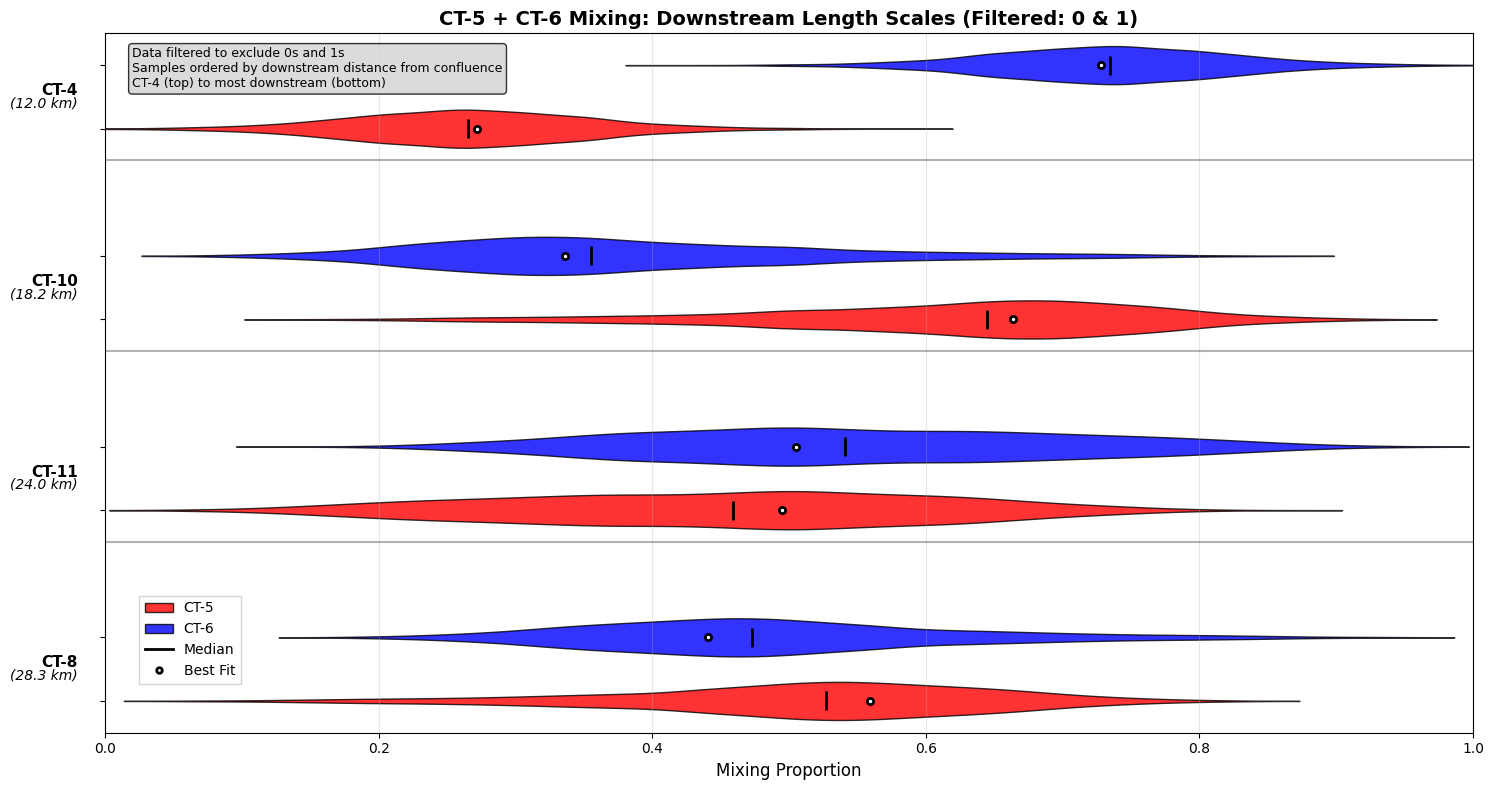

In [7]:
# Plot CT-5 and CT-6 mixing for samples at different downstream distances with filtering.    
# Define sample data in original order (will be sorted by distance later)
sample_names = ['CT-4', 'CT-10', 'CT-11', 'CT-8']
csv_files = [
        '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-4.csv',
        '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-10.csv',
        '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-11.csv',
        '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-8.2.csv'
    ]
    
# Best-fit mixing proportions for each sample (corresponding to sample_names order)
best_fit_values = [
        [0.272, 0.728],  # CT-4: 27.2% CT-5, 72.8% CT-6
        [0.664, 0.336],  # CT-10: 66.4% CT-5, 33.6% CT-6
        [0.495, 0.505],  # CT-11: 49.5% CT-5, 50.5% CT-6
        [0.559, 0.441]   # CT-8: 55.9% CT-5, 44.1% CT-6
    ]
    
# Create plot with legend and filtering
fig, ax, filtered_data = plot_downstream_violin_filtered(
    csv_files=csv_files,
    sample_names=sample_names,
    df_coords=df,
    best_fit_values_list=best_fit_values,
    labels=['CT-5', 'CT-6'],  # Component labels for legend
    colors=['red', 'blue'],   # Colors for CT-5 and CT-6 respectively
    title='CT-5 + CT-6 Mixing: Downstream Length Scales',
    save_path='Figures/downstream_mixing_length_scales_filtered.png',
    filter_zeros_ones=True    # Filter out end-member dominated samples
    )
    
plt.show()

## Be-10 downstream mixing

NameError: name 'FuncFormatter' is not defined

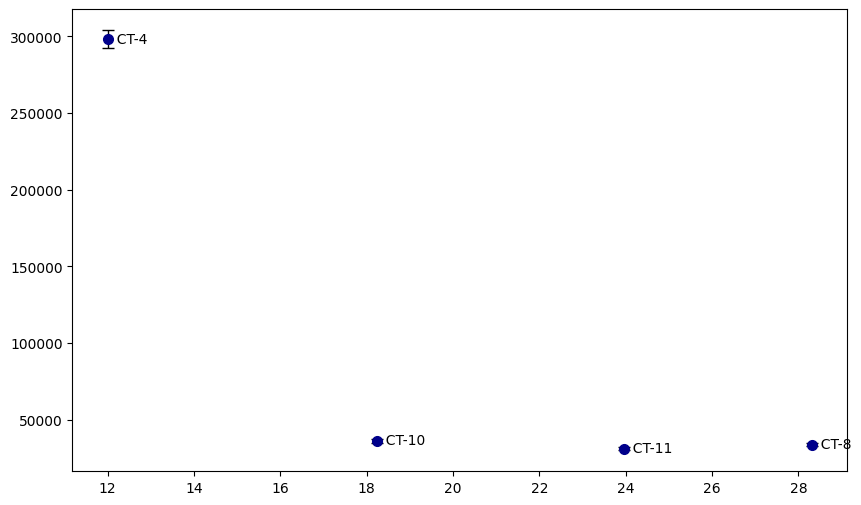

In [8]:
# Plotting the Be-10 vs distance downstream
# Only use downstream sequence samples
samples = ['CT-4', 'CT-10', 'CT-11', 'CT-8']
# Calculate distances
distances = calculate_downstream_distances(df, samples)
# Get data for plotting
plot_data = []
for sample in samples:
    row = df[df['Sample_ID'].str.contains(sample, case=False, na=False)]
    if not row.empty and sample in distances:
        r = row.iloc[0]
        be10_conc = r['10Be_concentration']
        be10_uncert = r['10Be_concentration_uncertainty']
        
        if pd.notna(be10_conc):
            plot_data.append({
                'sample': r['Sample_ID'],
                'distance': distances[sample],
                'be10_conc': be10_conc,
                'be10_uncert': be10_uncert if pd.notna(be10_uncert) else 0
            })
# Convert to DataFrame and sort by distance
plot_df = pd.DataFrame(plot_data).sort_values('distance')

# Create plot 
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data error bars
x_vals = plot_df['distance'].values
y_vals = plot_df['be10_conc'].values
y_err = plot_df['be10_uncert'].values

# Plot error bars
ax.errorbar(x_vals, y_vals, yerr=y_err, 
           fmt='o', markersize=7, capsize=4, capthick=1, 
           linewidth=1, color='darkblue', ecolor='black', 
           markerfacecolor='darkblue',
           zorder=3)

# Add sample labels
for _, row in plot_df.iterrows():
    ax.text(row['distance'], row['be10_conc'], f"  {row['sample']}", 
            verticalalignment='center', fontsize=10, zorder=4)

# Set log scale for y-axis
#ax.set_yscale('log')

# Make y-axis with scientific notation
#from matplotlib.ticker import LogLocator, FuncFormatter
#ax.yaxis.set_major_locator(LogLocator(base=10, numticks=8))
#ax.yaxis.set_minor_locator(LogLocator(base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=12))

# scientific notation
def format_func(x, p):
    if x >= 1e6:
        return f'{x/1e6:.1f}×10⁶'
    elif x >= 1e5:
        return f'{x/1e5:.1f}×10⁵'
    elif x >= 1e4:
        return f'{x/1e4:.1f}×10⁴'
    elif x >= 1e3:
        return f'{x/1e3:.1f}×10³'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# x-axis minor ticks
x_min, x_max = ax.get_xlim()
x_range = x_max - x_min
# Set major ticks
if x_range <= 20:
    major_spacing = 2.0
elif x_range <= 50:
    major_spacing = 5.0
else:
    major_spacing = 10.0
    
# Create major and minor ticks
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(major_spacing))
ax.xaxis.set_minor_locator(MultipleLocator(major_spacing/5))

# Format x-axis labels to show decimal places (e.g., 12.0)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
# Grid - only horizontal dashed lines for y-axis
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.8, alpha=0.7, color='gray')
ax.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4, alpha=0.3, color='gray')
ax.grid(True, axis='x', linestyle='--', linewidth=0.8, alpha=0.7)

# Labels and title
ax.set_xlabel('Distance Downstream (km)', fontsize=12)
ax.set_ylabel('¹⁰Be Concentration (atoms/g)', fontsize=12)
#ax.set_title('¹⁰Be vs Distance Downstream', fontsize=14)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=6)
ax.tick_params(axis='both', which='minor', direction='out', length=3)
plt.tight_layout()
plt.show()
print(plot_df[['sample', 'distance', 'be10_conc', 'be10_uncert']])
plt.savefig('Figures/downstream_mixing_Be-10.png')

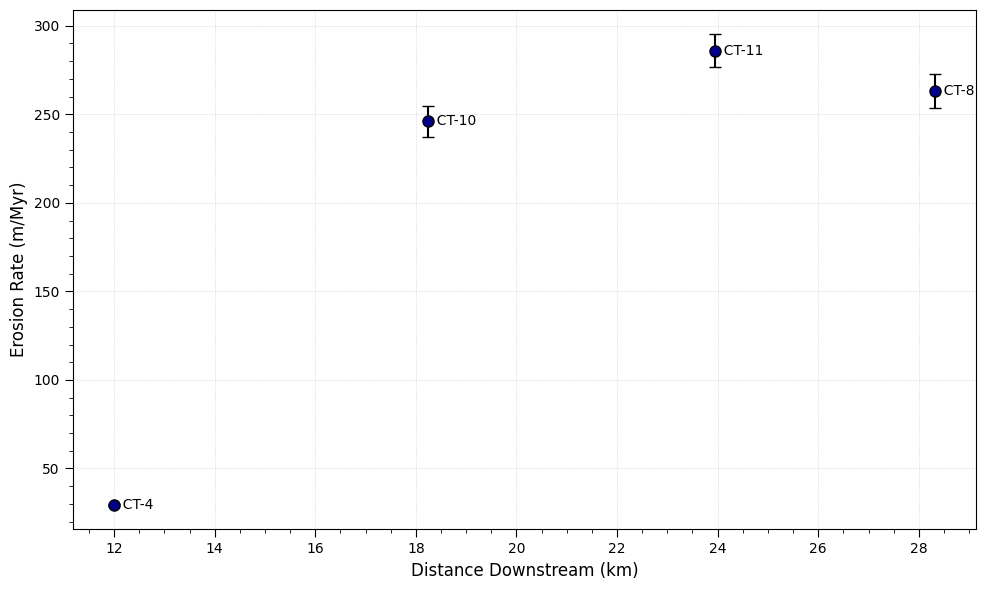

  sample   distance  erosion_rate  erosion_uncert
0   CT-4  12.000000          29.6           0.594
1  CT-10  18.232843         246.0           8.660
2  CT-11  23.951676         286.0           9.560
3   CT-8  28.316165         263.0           9.650


<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting the Erosion Rate vs distance downstream
# Only use downstream sequence samples
samples = ['CT-4', 'CT-10', 'CT-11', 'CT-8']
# Calculate distances
distances = calculate_downstream_distances(df, samples)
# Get data for plotting
plot_data = []
for sample in samples:
    row = df[df['Sample_ID'].str.contains(sample, case=False, na=False)]
    if not row.empty and sample in distances:
        r = row.iloc[0]
        erosion_rate = r['Erosion_rate']
        erosion_uncert = r['Erosion_rate_uncertainty_internal']
        
        if pd.notna(erosion_rate):
            plot_data.append({
                'sample': r['Sample_ID'],
                'distance': distances[sample],
                'erosion_rate': erosion_rate,
                'erosion_uncert': erosion_uncert if pd.notna(erosion_uncert) else 0
            })
# Convert to DataFrame and sort by distance
plot_df = pd.DataFrame(plot_data).sort_values('distance')
# Create plot with improved formatting
fig, ax = plt.subplots(figsize=(10, 6))
# Extract data for error bars
x_vals = plot_df['distance'].values
y_vals = plot_df['erosion_rate'].values
y_err = plot_df['erosion_uncert'].values
# Plot with error bars
ax.errorbar(x_vals, y_vals, yerr=y_err, 
           fmt='o', markersize=8, capsize=4, capthick=1, 
           linewidth=1.5, color='darkblue', ecolor='black', 
           markerfacecolor='darkblue', markeredgecolor='black',
           zorder=3)
# Add sample labels
for _, row in plot_df.iterrows():
    ax.text(row['distance'], row['erosion_rate'], f"  {row['sample']}", 
            verticalalignment='center', fontsize=10, zorder=4)
    
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.3, color='gray')

# Add minor ticks on both x and y axes
ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=6)
ax.tick_params(axis='both', which='minor', direction='out', length=3)
ax.minorticks_on()

# Labels and title
ax.set_xlabel('Distance Downstream (km)', fontsize=12)
ax.set_ylabel('Erosion Rate (m/Myr)', fontsize=12)
#ax.set_title('Erosion Rate vs Distance Downstream', fontsize=14)
plt.tight_layout()
plt.show()
print(plot_df[['sample', 'distance', 'erosion_rate', 'erosion_uncert']])
plt.savefig('Figures/downstream_mixing_erosionrate.png')

## Plotting all samples based on distance

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

def calculate_relative_distances(df, sample_names):
    """
    Calculate relative distances between samples based on lat/long coordinates.
    Distances calculated relative to the easternmost sample (assumed to be closest to confluence).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with sample data including lat/long columns
    sample_names : list
        List of sample names to calculate distances for
    
    Returns:
    --------
    dict : Dictionary with sample names as keys and relative distances as values
    """
    
    # Initialize dictionary to store coordinates for each sample
    sample_coords = {}
    for sample in sample_names:
        # Search for sample in DataFrame using case-insensitive partial matching
        sample_row = df[df['Sample_ID'].str.contains(sample, case=False, na=False)]
        if not sample_row.empty:
            # Extract latitude and longitude from first matching row
            lat = sample_row['Latitude'].iloc[0]
            lon = sample_row['Longitude'].iloc[0]
            sample_coords[sample] = (lat, lon)
        else:
            print(f"Warning: Sample '{sample}' not found in DataFrame")
    
    if not sample_coords:
        print("Error: No samples found in DataFrame")
        return {}
    
    # Find the easternmost sample (highest longitude) as the reference point
    easternmost_sample = max(sample_coords.keys(), key=lambda x: sample_coords[x][1])
    ref_coords = sample_coords[easternmost_sample]
    
    print(f"Using {easternmost_sample} as reference point (easternmost sample)")
    
    distances = {}
    
    # Calculate distances from easternmost sample for each sample
    for sample, coords in sample_coords.items():
        if sample == easternmost_sample:
            # Reference sample is at distance 0
            distances[sample] = 0.0
        else:
            # Calculate geodesic distance from reference sample
            dist_from_ref = geodesic(ref_coords, coords).kilometers
            distances[sample] = dist_from_ref
    
    return distances

In [34]:
def plot_original_style_all_samples(df):
    """
    Use the original plotting style but with all CT samples
    """
    # Use all CT samples instead of just the subset
    samples = [f'CT-{i}' for i in range(1, 12)]
    
    # Calculate distances
    distances = calculate_relative_distances(df, samples)
    
    # Get data for plotting (same as original code)
    plot_data = []
    for sample in samples:
        row = df[df['Sample_ID'].str.contains(sample, case=False, na=False)]
        if not row.empty and sample in distances:
            r = row.iloc[0]
            erosion_rate = r['Erosion_rate']
            erosion_uncert = r['Erosion_rate_uncertainty_internal']
            
            if pd.notna(erosion_rate):
                plot_data.append({
                    'sample': r['Sample_ID'],
                    'distance': distances[sample],
                    'erosion_rate': erosion_rate,
                    'erosion_uncert': erosion_uncert if pd.notna(erosion_uncert) else 0
                })
    
    # Convert to DataFrame and sort by distance
    plot_df = pd.DataFrame(plot_data).sort_values('distance')
    
    # Create plot with improved formatting (original style)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data for proper error bars
    x_vals = plot_df['distance'].values
    y_vals = plot_df['erosion_rate'].values
    y_err = plot_df['erosion_uncert'].values
    
    # Plot with proper error bars
    ax.errorbar(x_vals, y_vals, yerr=y_err, 
               fmt='o', markersize=8, capsize=4, capthick=1, 
               linewidth=1.5, color='darkblue', ecolor='black', 
               markerfacecolor='darkblue', markeredgecolor='black',
               zorder=3)
    
    # Add sample labels
    for _, row in plot_df.iterrows():
        ax.text(row['distance'], row['erosion_rate'], f"  {row['sample']}", 
                verticalalignment='center', fontsize=10, zorder=4)
        
    ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.3, color='gray')
    
    # Add minor ticks on both x and y axes
    ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=6)
    ax.tick_params(axis='both', which='minor', direction='out', length=3)
    ax.minorticks_on()
    
    # Labels and title
    ax.set_xlabel('Relative Distance (km)', fontsize=12)
    ax.set_ylabel('Erosion Rate (m/Myr)', fontsize=12)
    # ax.set_title('Erosion Rate vs Relative Distance', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    print(plot_df[['sample', 'distance', 'erosion_rate', 'erosion_uncert']])
    plt.savefig('Figures/downstream_mixing_erosionrate_all_samples.png')
    
    return plot_df

Using CT-7 as reference point (easternmost sample)


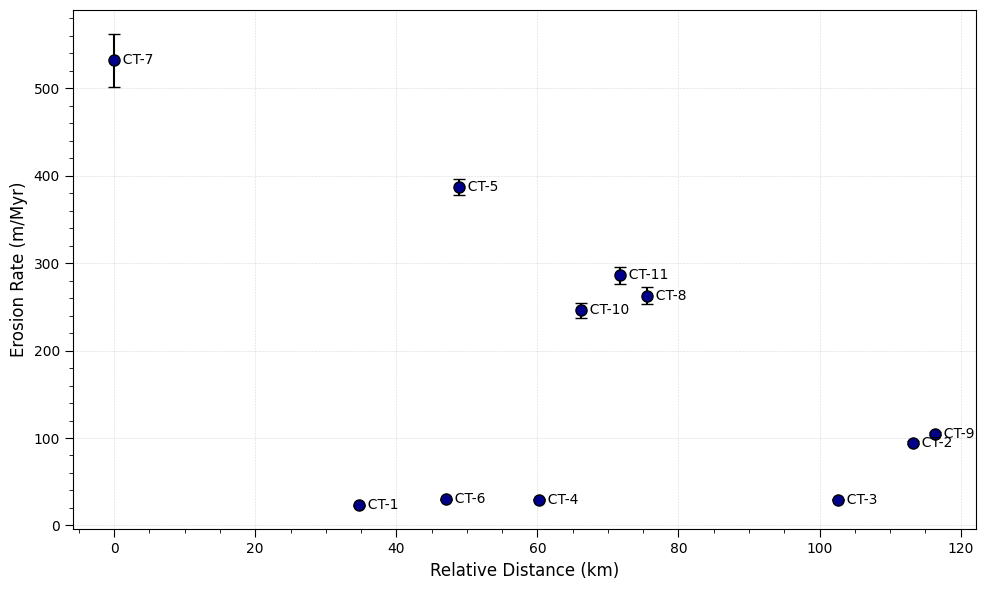

   sample    distance  erosion_rate  erosion_uncert
6    CT-7    0.000000         532.0          30.600
0    CT-1   34.670500          22.9           0.281
5    CT-6   47.077770          29.8           0.566
4    CT-5   48.824073         387.0           9.230
3    CT-4   60.251631          29.6           0.594
9   CT-10   66.127851         246.0           8.660
10  CT-11   71.741879         286.0           9.560
7    CT-8   75.475891         263.0           9.650
2    CT-3  102.667168          29.5           0.556
1    CT-2  113.191293          94.8           1.810
8    CT-9  116.323883         105.0           2.010


<Figure size 640x480 with 0 Axes>

In [35]:
plot_df = plot_original_style_all_samples(df)

In [36]:
 print(plot_df)

   sample    distance  erosion_rate  erosion_uncert
6    CT-7    0.000000         532.0          30.600
0    CT-1   34.670500          22.9           0.281
5    CT-6   47.077770          29.8           0.566
4    CT-5   48.824073         387.0           9.230
3    CT-4   60.251631          29.6           0.594
9   CT-10   66.127851         246.0           8.660
10  CT-11   71.741879         286.0           9.560
7    CT-8   75.475891         263.0           9.650
2    CT-3  102.667168          29.5           0.556
1    CT-2  113.191293          94.8           1.810
8    CT-9  116.323883         105.0           2.010


In [42]:
# CT-4 is 20km from confluence (reference point)
ct4_distance = plot_df[plot_df['sample'].str.contains('CT-4')]['distance'].iloc[0]
ct4_confluence_distance = 20  # km

# Calculate distance from confluence for all samples
plot_df['distance_from_confluence'] = ct4_confluence_distance + (plot_df['distance'] - ct4_distance)

# Specific samples
print(plot_df[plot_df['sample'].str.contains('CT-10|CT-11|CT-8')][['sample', 'distance_from_confluence']])

   sample  distance_from_confluence
9   CT-10                 25.876221
10  CT-11                 31.490249
7    CT-8                 35.224260
